# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
#from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib as mpl
data_type = 'float32'
#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

#import cell2location.models as c2l
#import cell2location.plt as c2lpl
#import cell2location.cluster_averages 
# import cell2location
# import pymc3 as pm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools
from itertools import cycle

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

# Barplots 

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'

sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

In [3]:
# Save anndata object with signatures
scvi_run_name = f'{results_folder}pyro/test_regression_normalisation_adam_lr0002'
adata_file = f"{scvi_run_name}_ref/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    regr_inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    regr_inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
regr_inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
regr_inf_aver.iloc[0:5, 0:5]

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO
ENSEMBL,,,,,
ENSMUSG00000051951,0.050511,0.105329,0.039299,0.176706,0.032688
ENSMUSG00000089699,0.031588,0.025723,0.008132,0.014632,0.032263
ENSMUSG00000033845,0.140224,0.064763,0.073241,0.065900,0.087580
ENSMUSG00000033813,0.085916,0.130148,0.180947,0.105858,0.070225
ENSMUSG00000002459,2.846514,3.509084,3.756964,4.002057,1.390353


In [4]:
r_load = {'run_name': 'test_simplified2_alpha200_lr0.002_max_epochs40000_LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data'}

fig_path=results_folder+'pyro/' +r_load['run_name']+'/plots'

sp_data_file = results_folder+'pyro/' +r_load['run_name']+'/sp.h5ad'
adata_vis_res = adata_vis = anndata.read(sp_data_file)

In [5]:
adata_vis_res.obsm

AxisArrays with keys: X_spatial, means_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf, stds_cell_abundance_w_sf

In [6]:
from re import sub
cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
umi_count = adata_vis_res.obs.loc[:, ['UMI_count_' in i for i in adata_vis_res.obs.columns]]
umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

#spot_factors = adata_vis_res.obs[['mean_w_sf' + i for i in cell_count_columns]]
#spot_factors.columns =  [sub('mean_w_sf', '', i) for i in spot_factors.columns]
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis_res.obs[adata_vis_res.uns['mod']['factor_names']] = adata_vis_res.obsm['q05_cell_abundance_w_sf']
spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
spot_factors.columns = adata_vis_res.uns['mod']['factor_names']

#spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
#spot_factors_sd.columns =  [sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

infer_cell_count = spot_factors[cell_count.columns]
#infer_cell_count = cells_per_factor[cell_count.columns]

#nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
#nUMI_factors.columns =  [sub('mean_nUMI_factors', '', i) for i in nUMI_factors.columns]

In [7]:
infer_cell_count = spot_factors[cell_count.columns]
#infer_nUMI_count = nUMI_factors[cell_count.columns]

In [8]:
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

cell2loc_df = infer_cell_proportions

In [9]:
stereo_path_1 = f'{results_folder}scvi_stereoscope/'
scvi_stereoscope = anndata.read(f'{stereo_path_1}sp_n_epochs30k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[cell_count.index,:]
stereo_df = scvi_stereoscope[cell_count.columns]

In [10]:
# read cell proportions
nnls_path_1 = results_folder + 'autogenes_models/coef_nnls_seed.csv'
nnls_df = pd.read_csv(nnls_path_1, sep=',', index_col=0).T

# compute proportions per location
nnls_df = (nnls_df.T / nnls_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
nnls_df = nnls_df.loc[nnls_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[nnls_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
nnls_df = nnls_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [11]:
# read cell proportions
RCTD_path_1 = results_folder + 'rctd/results_weights.csv'
RCTD_df = pd.read_csv(RCTD_path_1, sep=',', index_col='spot')

# compute proportions per location
RCTD_df_orig = RCTD_df.copy()
RCTD_df = (RCTD_df.T / RCTD_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
RCTD_df = RCTD_df.loc[RCTD_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[RCTD_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
RCTD_df = RCTD_df_orig[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [12]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/results_pca.csv'
seurat_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_df = seurat_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_df.columns = [sub('prediction.score.', '', i) for i in seurat_df.columns]

# compute proportions per location
seurat_df = (seurat_df.T / seurat_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_df = seurat_df.loc[seurat_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
seurat_df = seurat_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [13]:
# read cell proportions
spotlight_path_1 = results_folder + 'SPOTlight/results_hvg5k.csv'
spotlight_df = pd.read_csv(spotlight_path_1, sep=',', index_col='rn')
spotlight_df = spotlight_df.drop(columns=['res_ss'])

from re import sub

seu_index = [sub(' ', '.',i) for i in cell_proportions.columns]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]
seu_index = [sub('_', '.',i) for i in seu_index]

spotlight_df = spotlight_df[seu_index]
spotlight_df.columns = cell_proportions.columns

# compute proportions per location (already proportions)
#spotlight_df = (spotlight_df.T / spotlight_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
spotlight_df = spotlight_df.loc[spotlight_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[spotlight_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
spotlight_df = spotlight_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [14]:
cell_prop_dfs = [cell2loc_df, stereo_df, seurat_df, RCTD_df, spotlight_df, nnls_df]
method_names = ['Cell2location', 'Stereoscope', 'Seurat', 'RCTD', 'SPOTlight', 'NNLS']

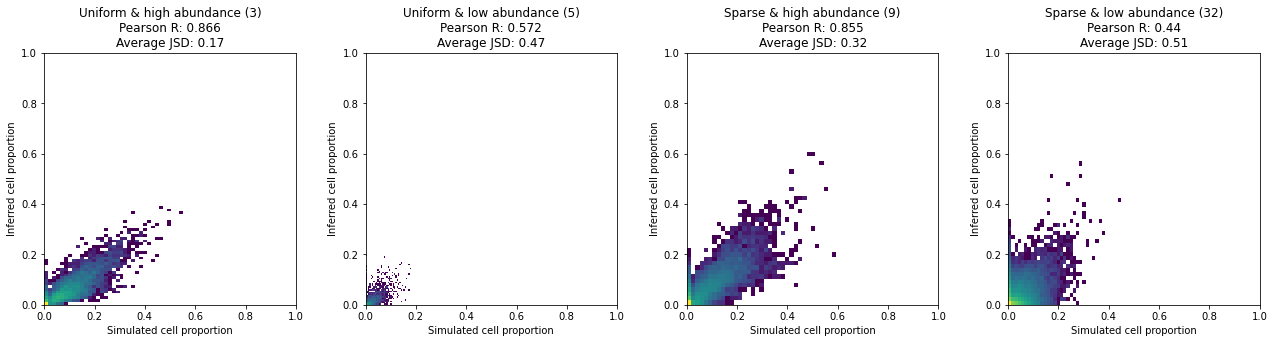

In [16]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'Pearson R: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=matplotlib.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_proportions, infer_cell_proportions, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 #compute_kl=False, 
                 nrow=1, ncol=4, equal=True)
plt.tight_layout()

plt.savefig(fig_path + '/hist_by_category.pdf', bbox_inches='tight')

In [17]:
cell_proportions.columns == adata_vis_res.uns['design']['cell_types2zones'].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

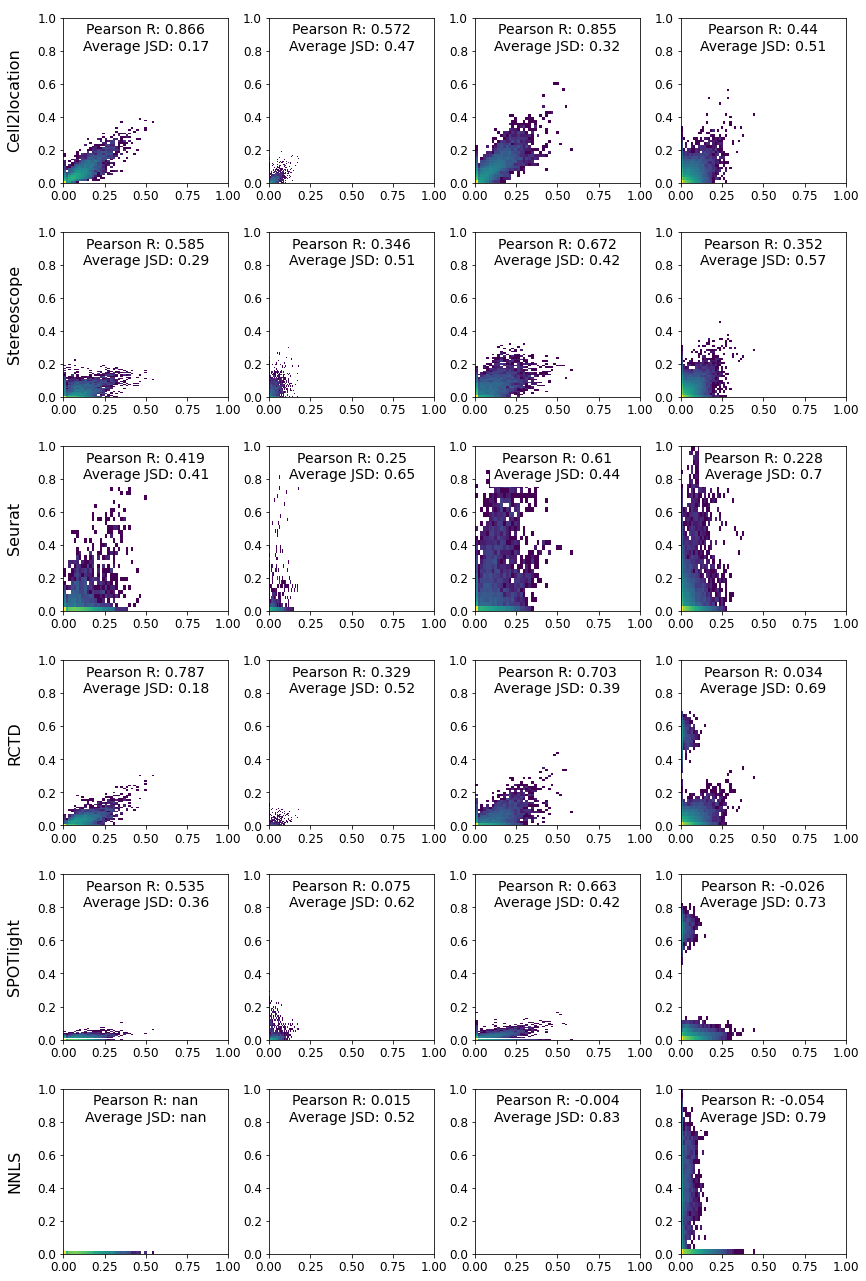

In [18]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1, ax=None):
    
    if ax is None:
        ax = plt.gca()
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'Pearson R: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    ax.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=matplotlib.colors.LogNorm());
    ax.set_xlabel(xlab);
    ax.set_ylabel(ylab);
    if equal:
        ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, max_val);
    ax.set_ylim(0, max_val);
    ax.set_title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True, axs=None):
    
    if axs is None:
        axs = [None] * 4

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    if axs[0] is None:
        plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[0])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[1])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[2])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[3])



with mpl.rc_context({'xtick.labelsize': 12, 'ytick.labelsize': 12}):
    fig, axs = plt.subplots(len(cell_prop_dfs), 4, figsize=(12, 18))
    for df, ax, name in zip(cell_prop_dfs, axs, method_names):
        hist_by_category(cell_proportions, df, adata_vis_res.uns['design']['cell_types2zones'],
                     xlab='Simulated cell proportion',
                     ylab='Inferred cell proportion', axs=ax)
        for ax_ in ax:
            ax_.set_title(ax_.get_title(), y=0.765, backgroundcolor='white', zorder=1, size=14)
            ax_.set_xlabel('')
            ax_.set_ylabel('')
            if ax_.is_first_col():
                ax_.set_ylabel(name, size=16, labelpad=15)

    plt.tight_layout()
    plt.savefig(fig_path + '/hist_by_category_all_methods.pdf', bbox_inches='tight')
    plt.show()

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

from functools import partial
from itertools import cycle

def swap_return_order(f, order, *args, **kwargs):
    result = f(*args, **kwargs)
    return [result[i] for i in order]


with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']



def compute_curve(pos_cell_count, infer_cell_proportions, mode='macro', curve='AUC'):
    r"""
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, infer_cell_proportions.shape)
    
    X = dict()
    Y = dict()
    scores = dict()
    
    if curve == 'ROC':
        # in this case X is FPR and Y is TPR
        curve_function = partial(swap_return_order, roc_curve, [1, 0, 2])
        score_function = roc_auc_score
        
    elif curve == 'PR':
        # in this case X is recall and Y is precision
        curve_function = precision_recall_curve
        score_function = average_precision_score
        
    for i, c in enumerate(infer_cell_proportions.columns):
        Y[c], X[c], _ = curve_function(pos_cell_count[:, i], predictor[:, i])
        scores[c] = score_function(pos_cell_count[:, i], predictor[:, i], average=mode)

    scores["averaged"] = score_function(pos_cell_count, predictor, average=mode)
    
    if mode == 'micro':
        Y["averaged"], X["averaged"], _ = curve_function(pos_cell_count.ravel(), predictor.ravel())

    elif mode == 'macro':
        Ys = []
        x_grid = np.linspace(0, 1, 2000)
        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(X[c], Y[c])
            y_interp = f(x_grid)
            Ys.append(y_interp)

        X["averaged"] = x_grid
        Y['averaged'] = np.mean(Ys, axis=0)
    return X, Y, scores 

compute_roc = partial(compute_curve, curve='ROC')
compute_precision_recall = partial(compute_curve, curve='PR')

def plot_curve(pos_cell_count, infer_cell_proportions,
                          title='', individual_cell_types=True,
                          mode='macro', curve='PR', 
                          ax=None, save=None, color='navy', lw=2, legend=True):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        xlabel = 'FPR'
        ylabel = 'TPR'
    
    X, Y, scores = compute_curve(pos_cell_count, infer_cell_proportions, mode=mode, curve=curve)
    
    ### plotting ###
    if ax is None:
        ax = plt.gca()
        
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    l = ax.plot(X["averaged"], Y["averaged"], color=color, lw=lw)
    lines.append(l[0])
    labels.append(f'{mode}-average {curve} ({curve} score = {scores["averaged"] :.2f})')
    
    


    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l = ax.plot(X[i], Y[i], color='gold', lw=1)
        lines.append(l[0])
        labels.append(f'{curve} for individual cell types')
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if legend:
        ax.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))

    if save is not None:
        plt.savefig(save)
        
    return ax, scores
    

plot_roc = partial(plot_curve, curve='ROC')
plot_precision_recall = partial(plot_curve, curve='PR')


def compare_curve(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR', lw=2,
                             font_size=12):
    
    r""" Plot precision-recall/ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    score = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        ax, score = plot_curve(pos_cell_count, infer_cell_proportions[i], color=color, 
                               individual_cell_types=False, curve=curve, mode=mode, lw=lw, legend=legend_loc)
        lines.append(ax.lines[-1])
        labels.append(method_title[i] + '(' + curve + ' score = {0:0.2f})'
                      ''.format(score["averaged"]))
        score[method_title[i]] = score["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=font_size))

    #plt.show()
    return score

compare_roc = partial(compare_curve, curve='ROC')
compare_precision_recall = partial(compare_curve, curve='PR')

In [20]:
def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        patch.set_x(patch.get_x() + shrink * (round(patch.get_x()) - patch.get_x()) - shift)
        
def show_values_on_bars(axs, text_size=9):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.01
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", size=text_size) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [21]:
from scipy import interpolate
def calculate_r2(cell_count, infer_cell_count):
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    return cor

def get_stat_for_types_generic(cell_count, infer_cell_count, design, calculate_stat):
    design_loc = design.loc[cell_count.columns,:]
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    types_data['Ubiquitous & \nHigh abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    types_data['Ubiquitous & \nLow abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    types_data['Regional & \nHigh abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    types_data['Regional & \nLow abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    return pd.DataFrame([types_data.values()], columns=types_data.keys(), index=[1])

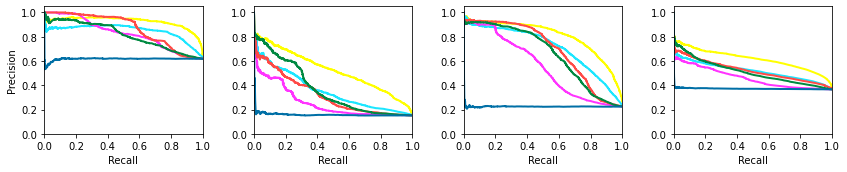

In [22]:
pos_cell_count = cell_count >= 0.1
design_loc = adata_vis_res.uns['design']['cell_types2zones']

plt.figure(figsize=(12, 2.5))

plt.subplot(1, 4, 1)
ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
compare_precision_recall(pos_cell_count.loc[:,ind].values, 
                         [df.loc[:,ind] for df in cell_prop_dfs],
                         method_title=method_names, 
                         legend_loc=None);

plt.subplot(1, 4, 2)
ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
compare_precision_recall(pos_cell_count.loc[:,ind].values, 
                         [df.loc[:,ind] for df in cell_prop_dfs],
                         method_title=method_names, 
                         legend_loc=None);
plt.ylabel('')

plt.subplot(1, 4, 3)
ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
compare_precision_recall(pos_cell_count.loc[:,ind].values, 
                         [df.loc[:,ind] for df in cell_prop_dfs],
                         method_title=method_names, 
                         legend_loc=None);
plt.ylabel('')

plt.subplot(1, 4, 4)
ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
compare_precision_recall(pos_cell_count.loc[:,ind].values, 
                         [df.loc[:,ind] for df in cell_prop_dfs],
                         method_title=method_names, 
                         legend_loc=None);
plt.ylabel('')
plt.tight_layout()

plt.savefig(fig_path + '/3S_B_PR_curves_by_type.pdf', bbox_inches='tight')

In [23]:
###### corr ######
get_r2_df_short = partial(get_stat_for_types_generic, cell_count=cell_proportions,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=calculate_r2)

r2_data = pd.concat([get_r2_df_short(infer_cell_count=df) for df in cell_prop_dfs])
r2_data['method'] = method_names
r2_data_melted = pd.melt(r2_data, id_vars=['method'], value_vars=r2_data.columns[:-1])

###### PR ######
pos_cell_count = cell_count >= 0.1

get_PR = lambda x, y: compute_precision_recall(x.values, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in cell_prop_dfs])
pr_data['method'] = method_names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

###### ROC ######
#ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

#get_ROC = lambda x, y: compute_roc(x.values, y, mode='macro')[2]['averaged']

#get_ROC_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
#                          design=adata_vis_res.uns['design']['cell_types2zones'],
#                          calculate_stat=get_ROC)

#roc_data = pd.concat([get_ROC_df_short(infer_cell_count=df) for df in cell_prop_dfs])
#roc_data['method'] = method_names
#roc_data_melted = pd.melt(roc_data, id_vars=['method'], value_vars=pr_data.columns[:-1])


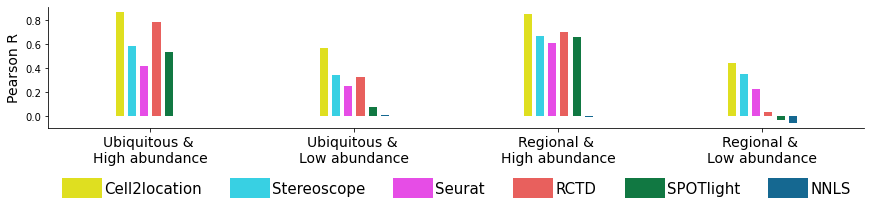

In [24]:
plt.figure(figsize=(12.2, 3.5))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=r2_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .04, shrink=0.55, shift=0.01)
plt.xlabel('');
plt.ylabel('Pearson R', size=14);
plt.xticks(size=14, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.65,  1, 0.3), mode='expand', ncol=6, 
           fontsize=15, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(20)
    handle.set_width(40)
    handle.set_y(-4)
plt.tight_layout();

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.savefig(fig_path + '/barplot_microaverage_Pearson_R_abundance.pdf', bbox_inches='tight')

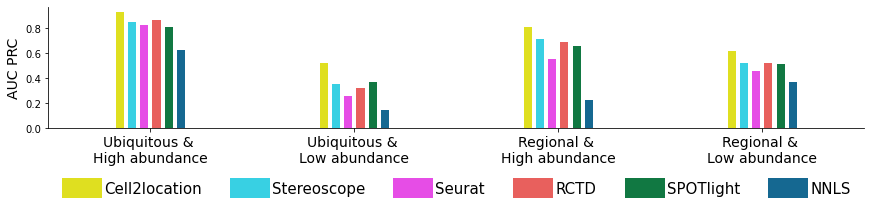

In [25]:
plt.figure(figsize=(12.2, 3.5))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .04, shrink=0.55, shift=0.01)
plt.xlabel('');
plt.ylabel('AUC PRC', size=14);
plt.xticks(size=14, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.65,  1, 0.3), mode='expand', ncol=6, 
           fontsize=15, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(20)
    handle.set_width(40)
    handle.set_y(-4)
plt.tight_layout();

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

plt.savefig(fig_path + '/barplot_PR_abundance.pdf', bbox_inches='tight')

## Bar plot separating cell types by txn distinctiveness

Astro_AMY_CTX      18.959678
Astro_HPC          18.959678
Astro_AMY          20.465476
Astro_HYPO         23.501640
Astro_THAL_lat     23.501640
Astro_CTX          25.350014
Astro_WM           31.430225
Micro              36.516341
Unk_1              36.516341
Astro_THAL_med     44.851669
Nb_1               50.151076
Nb_2               52.681055
Inh_Meis2_3        58.234154
Inh_Meis2_2        58.234154
OPC_1              59.249331
Inh_4              59.716020
Inh_1              59.716020
Oligo_2            66.847428
Inh_3              70.822464
Ext_L5_1           76.320151
Ext_L6B            76.320151
Inh_Meis2_1        81.634047
Ext_L6             82.230267
Ext_L5_2           82.230267
Ext_L25            91.328045
Inh_Vip            95.565146
Inh_Lamp5          95.565146
Inh_Sst            98.267358
Inh_2              98.267358
LowQ_2             98.423748
Inh_6             102.377914
Inh_5             107.502632
Ext_Hpc_DG2       109.822063
Ext_L56           113.385985
Ext_Unk_3     

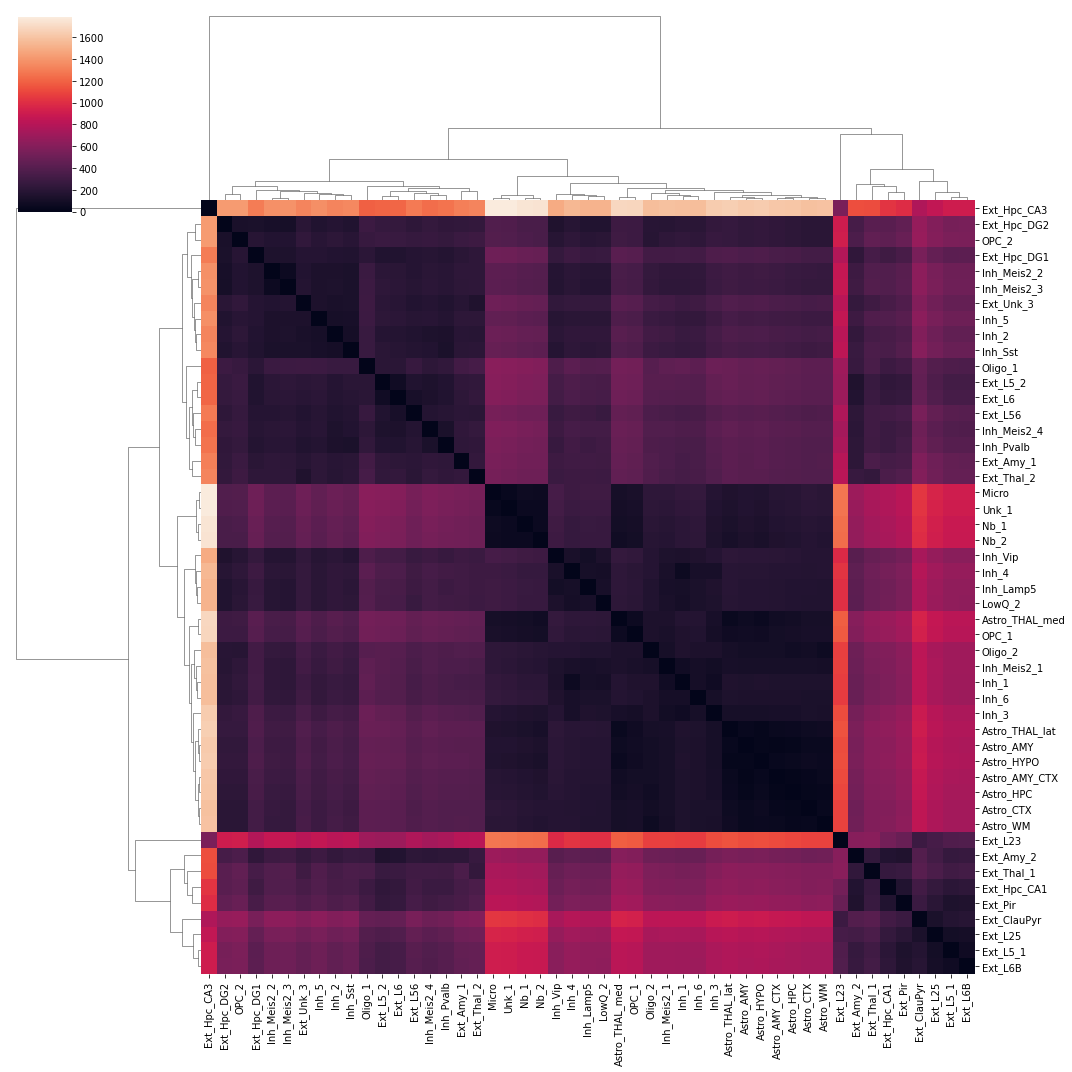

In [26]:
from scipy.spatial.distance import cdist
ct_dist = cdist(regr_inf_aver.T, regr_inf_aver.T, metric='euclidean')
ct_dist = pd.DataFrame(ct_dist, index=regr_inf_aver.columns, columns=regr_inf_aver.columns)

sns.clustermap(ct_dist, figsize=(15, 15))

distinctiveness = pd.DataFrame(np.array(
    [[ct_dist[c].sort_values()[1:4].mean() for c in ct_dist.columns],
     [ct_dist[c].sort_values()[1].mean() for c in ct_dist.columns]]
).T,
             index=ct_dist.columns, columns=['top3_average_distance', 'min_distance'])

distinctiveness['min_distance'].sort_values()

In [27]:
design = distinctiveness#.loc[cell_prop_dfs[1].columns,:]
design['min_distance'].sort_values()

Astro_AMY_CTX      18.959678
Astro_HPC          18.959678
Astro_AMY          20.465476
Astro_HYPO         23.501640
Astro_THAL_lat     23.501640
Astro_CTX          25.350014
Astro_WM           31.430225
Micro              36.516341
Unk_1              36.516341
Astro_THAL_med     44.851669
Nb_1               50.151076
Nb_2               52.681055
Inh_Meis2_3        58.234154
Inh_Meis2_2        58.234154
OPC_1              59.249331
Inh_4              59.716020
Inh_1              59.716020
Oligo_2            66.847428
Inh_3              70.822464
Ext_L5_1           76.320151
Ext_L6B            76.320151
Inh_Meis2_1        81.634047
Ext_L6             82.230267
Ext_L5_2           82.230267
Ext_L25            91.328045
Inh_Vip            95.565146
Inh_Lamp5          95.565146
Inh_Sst            98.267358
Inh_2              98.267358
LowQ_2             98.423748
Inh_6             102.377914
Inh_5             107.502632
Ext_Hpc_DG2       109.822063
Ext_L56           113.385985
Ext_Unk_3     

In [28]:
design['is_txn_fine'] = 1-np.digitize(design['min_distance'].values,
                                      [100]
                                      #np.histogram(distinctiveness['min_distance'].values, bins=4)[1]
                                     )
design, design['is_txn_fine'].value_counts()

(                top3_average_distance  min_distance  is_txn_fine
 Astro_AMY                   24.370134     20.465476            1
 Astro_AMY_CTX               23.539272     18.959678            1
 Astro_CTX                   32.105511     25.350014            1
 Astro_HPC                   23.918752     18.959678            1
 Astro_HYPO                  29.274640     23.501640            1
 Astro_THAL_lat              34.636888     23.501640            1
 Astro_THAL_med              53.216580     44.851669            1
 Astro_WM                    38.183227     31.430225            1
 Ext_Amy_1                  191.945829    186.667515            0
 Ext_Amy_2                  155.932771    152.385714            0
 Ext_ClauPyr                161.707903    126.844416            0
 Ext_Hpc_CA1                175.600475    155.833597            0
 Ext_Hpc_CA3                724.578698    555.729092            0
 Ext_Hpc_DG1                139.693198    127.786104            0
 Ext_Hpc_D

In [29]:
sel_ind = (adata_vis_res.uns['design']['cell_types2zones']['is_uniform'] == 0) \
& (adata_vis_res.uns['design']['cell_types2zones']['is_high_density'] == 0)
sel_ind = sel_ind.index[sel_ind.values]

design_regional_low = design.loc[sel_ind,:]

In [30]:
def get_stat_for_types_txn_fine(cell_count, infer_cell_count, design, calculate_stat):
    design_loc = design.loc[infer_cell_count.columns,:]
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    ind = design_loc['is_txn_fine'].values.astype(bool)
    types_data['Transcriptionally fine'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ~ design_loc['is_txn_fine'].values.astype(bool)
    types_data['Transcriptionally distinct'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    return pd.DataFrame(types_data, index=[1])

In [31]:
###### corr ######
get_r2_df_short = partial(get_stat_for_types_txn_fine, cell_count=cell_proportions[sel_ind],
                          design=design_regional_low,
                          calculate_stat=calculate_r2)

r2_data = pd.concat([get_r2_df_short(infer_cell_count=df[sel_ind]) for df in cell_prop_dfs])
r2_data['method'] = method_names
r2_data_melted = pd.melt(r2_data, id_vars=['method'], value_vars=r2_data.columns[:-1])

###### PR ######
pos_cell_count = cell_count > 0.1

get_PR = lambda x, y: compute_precision_recall(x.values, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_txn_fine, cell_count=pos_cell_count[sel_ind],
                          design=design_regional_low,
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df[sel_ind]) for df in cell_prop_dfs])
pr_data['method'] = method_names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])

###### ROC ######
#get_ROC = lambda x, y: compute_roc(x.values, y, mode='macro')[2]['averaged']

#get_ROC_df_short = partial(get_stat_for_types_txn_fine, cell_count=pos_cell_count[sel_ind],
#                          design=design_regional_low,
#                         calculate_stat=get_ROC)

#roc_data = pd.concat([get_ROC_df_short(infer_cell_count=df[sel_ind]) for df in cell_prop_dfs])
#roc_data['method'] = method_names
#roc_data_melted = pd.melt(roc_data, id_vars=['method'], value_vars=roc_data.columns[:-1])


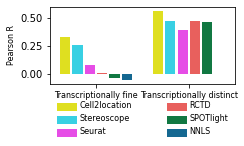

In [32]:
plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=r2_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

plt.savefig(fig_path + '/barplot_PearsonR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

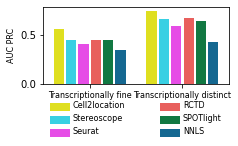

In [33]:
plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="variable", y="value",
                hue="method",
                data=pr_data_melted, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('AUC PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

plt.savefig(fig_path + '/barplot_PR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

### Look at variance explained in PRC

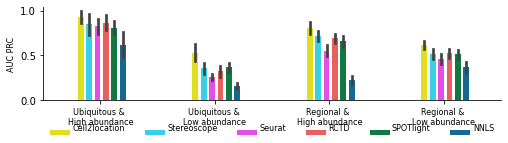

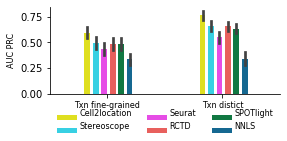

In [34]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch, line in zip(ax.patches, ax.lines) :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        x_orig = patch.get_x()
        patch.set_x(x_orig + diff * .5)
        x_orig = patch.get_x()
        patch.set_x(x_orig + shrink * (round(x_orig) - x_orig))
        
        line.set_xdata(line.get_xdata() + shrink * (np.round(x_orig) - x_orig))

get_PR_values = lambda x, y: list(remove_avg(compute_precision_recall(x.values, y, mode='macro')[2]).values())

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=get_PR_values)

dfs_detailed = []
for df, method in zip(cell_prop_dfs, method_names):
    df_detailed = pd.DataFrame({'value': get_PR_values(pos_cell_count, df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_uniform'] = adata_vis_res.uns['design']['cell_types2zones']['is_uniform'][df.columns].values
    df_detailed['is_high_density'] = adata_vis_res.uns['design']['cell_types2zones']['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['max_density'] = adata_vis_res.uns['design']['cell_types2zones'].drop(columns=['is_uniform', 'is_high_density']).max(1)[df.columns].values
    df_detailed['method'] = method
    
    df_detailed['value_normalised_by_density'] = df_detailed['value'] / df_detailed['max_density']
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)

pr_data_values['Fig1_categories'] = ''
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nHigh abundance'
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (~ pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nLow abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nHigh abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (~pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nLow abundance'
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].astype('category')
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].cat.reorder_categories([
    'Ubiquitous & \nHigh abundance', 'Ubiquitous & \nLow abundance',
    'Regional & \nHigh abundance', 'Regional & \nLow abundance'
])

pr_data_values['Fig1_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig1_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig1_txn_categories'] = \
'Txn distict'
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].astype('category')
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    #g = sns.boxplot(x=x, y=y,
    #                hue="method",
    #                data=pr_data_values, palette=sc.pl.palettes.default_102);
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    
    #change_width(g, .10)
    change_width(g, .05, shrink=0.45, shift=0.01)
    
    plt.xlabel('');
    plt.ylabel('AUC PRC', size=8);
    plt.xticks(size=8, ha='center');
    # lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), ncol=1, 
    #            fontsize=15, frameon=False);

    lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.45,  1, 0.3), mode='expand', ncol=n_leged_col, 
               fontsize=8, frameon=False);

    for handle in lgnd.legendHandles:
         handle.set_height(5)
         handle.set_width(20)
         handle.set_y(-4)
    plt.tight_layout();

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    # ax = plt.gca()
    # ax.set_xticks(ax.get_xticks() + 0.4)
    # plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
plt.figure(figsize=(7.25, 2.2))
plot_boxplot_prc('Fig1_categories', n_leged_col=6)
plt.savefig(fig_path + '/barplot_Fig1_abundance_categories_PRC.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4., 2.2))
plot_boxplot_prc('Fig1_txn_categories', n_leged_col=3)
plt.savefig(fig_path + '/barplot_Fig1_txn_categories_PRC.pdf', bbox_inches='tight')
plt.show()

#### Look at variance explained in PRC

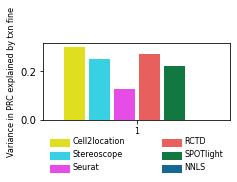

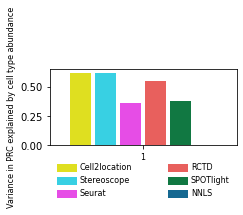

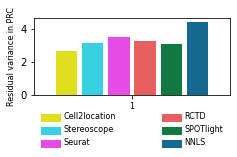

In [35]:
def variance_explained(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    anova_res['perc_sq'] = anova_res['sum_sq']# / anova_res['sum_sq']['Residual']
    return anova_res


var_expl_df = pd.DataFrame([variance_explained(pr_data_values.loc[pr_data_values['method'] == method,:])['perc_sq']
              for method in method_names], index=method_names)
var_expl_df['method'] = method_names
var_expl_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Variance in PRC explained by txn fine', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Variance in PRC explained by cell type abundance', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Residual",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Residual variance in PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

#plt.savefig(fig_path + '/barplot_PR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

#### Look at % variance explained in PRC

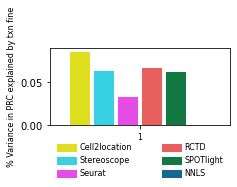

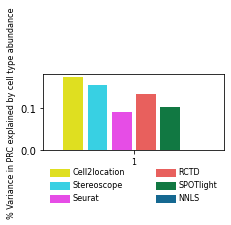

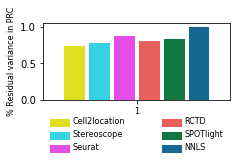

In [36]:
def variance_explained(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    anova_res['perc_sq'] = anova_res['sum_sq'] / anova_res['sum_sq'].sum()
    return anova_res


var_expl_df = pd.DataFrame([variance_explained(pr_data_values.loc[pr_data_values['method'] == method,:])['perc_sq']
              for method in method_names], index=method_names)
var_expl_df['method'] = method_names
var_expl_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Variance in PRC explained by txn fine', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Variance in PRC explained by cell type abundance', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Residual",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Residual variance in PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

#plt.savefig(fig_path + '/barplot_PR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

### Look at effects on PRC

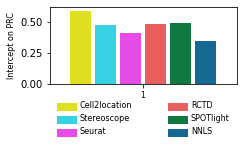

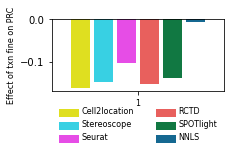

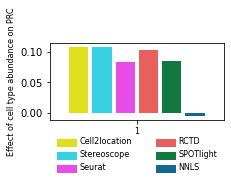

In [37]:
def lm(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    #anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    #anova_res['perc_sq'] = anova_res['sum_sq'] / anova_res['sum_sq']['Residual']
    return lm_model

effect_df = pd.DataFrame([lm(pr_data_values.loc[pr_data_values['method'] == method,:]).params 
 for method in method_names], index=method_names)

effect_df['method'] = method_names
effect_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Intercept",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Intercept on PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)[T.1]",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Effect of txn fine on PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Effect of cell type abundance on PRC', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

### Look at variance explained in Pearson R

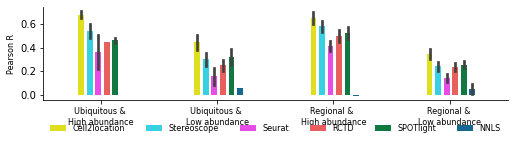

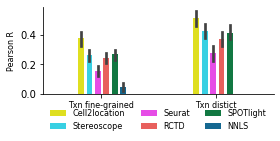

In [38]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch, line in zip(ax.patches, ax.lines) :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        x_orig = patch.get_x()
        patch.set_x(x_orig + diff * .5)
        x_orig = patch.get_x()
        patch.set_x(x_orig + shrink * (round(x_orig) - x_orig))
        
        line.set_xdata(line.get_xdata() + shrink * (np.round(x_orig) - x_orig))

get_PR_values = lambda x, y: np.array([calculate_r2(x.iloc[:,i], y.iloc[:,i]) for i in range(y.shape[1])])

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=get_PR_values)

dfs_detailed = []
for df, method in zip(cell_prop_dfs, method_names):
    df_detailed = pd.DataFrame({'value': get_PR_values(pos_cell_count, df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_uniform'] = adata_vis_res.uns['design']['cell_types2zones']['is_uniform'][df.columns].values
    df_detailed['is_high_density'] = adata_vis_res.uns['design']['cell_types2zones']['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['max_density'] = adata_vis_res.uns['design']['cell_types2zones'].drop(columns=['is_uniform', 'is_high_density']).max(1)[df.columns].values
    df_detailed['method'] = method
    
    df_detailed['value_normalised_by_density'] = df_detailed['value'] / df_detailed['max_density']
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)

pr_data_values['Fig1_categories'] = ''
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nHigh abundance'
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (~ pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nLow abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nHigh abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (~pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nLow abundance'
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].astype('category')
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].cat.reorder_categories([
    'Ubiquitous & \nHigh abundance', 'Ubiquitous & \nLow abundance',
    'Regional & \nHigh abundance', 'Regional & \nLow abundance'
])

pr_data_values['Fig1_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig1_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig1_txn_categories'] = \
'Txn distict'
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].astype('category')
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    #g = sns.boxplot(x=x, y=y,
    #                hue="method",
    #                data=pr_data_values, palette=sc.pl.palettes.default_102);
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    #change_width(g, .10)
    change_width(g, .05, shrink=0.45, shift=0.01)
    plt.xlabel('');
    plt.ylabel('Pearson R', size=8);
    plt.xticks(size=8, ha='center');
    # lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), ncol=1, 
    #            fontsize=15, frameon=False);

    lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.45,  1, 0.3), mode='expand', ncol=n_leged_col, 
               fontsize=8, frameon=False);

    # for handle in lgnd.legendHandles:
    #     handle.set_height(20)
    #     handle.set_width(40)
    #     handle.set_y(-4)
    # 
    plt.tight_layout();

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    # ax = plt.gca()
    # ax.set_xticks(ax.get_xticks() + 0.4)
    # plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
    
plt.figure(figsize=(7.25, 2.2))
plot_boxplot_prc('Fig1_categories', n_leged_col=6)
plt.savefig(fig_path + '/barplot_Fig1_abundance_categories_Pearson_R.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4., 2.2))
plot_boxplot_prc('Fig1_txn_categories', n_leged_col=3)
plt.savefig(fig_path + '/barplot_Fig1_txn_categories_Pearson_R.pdf', bbox_inches='tight')
plt.show()

In [39]:
pr_data_values['is_uniform'].value_counts()

0    246
1     48
Name: is_uniform, dtype: int64

#### Look at variance explained in Pearson R

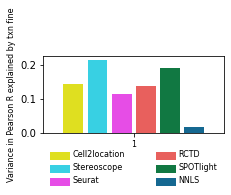

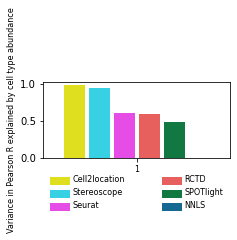

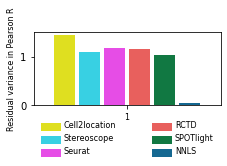

In [40]:
def variance_explained(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    anova_res['perc_sq'] = anova_res['sum_sq']# / anova_res['sum_sq']['Residual']
    return anova_res


var_expl_df = pd.DataFrame([variance_explained(pr_data_values.loc[pr_data_values['method'] == method,:])['perc_sq']
              for method in method_names], index=method_names)
var_expl_df['method'] = method_names
var_expl_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Variance in Pearson R explained by txn fine', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Variance in Pearson R explained by cell type abundance', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Residual",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Residual variance in Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

#plt.savefig(fig_path + '/barplot_PR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

#### Look at % variance explained in Pearson R

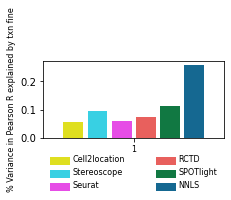

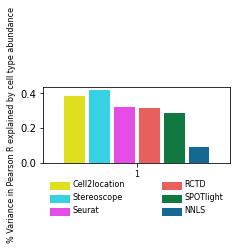

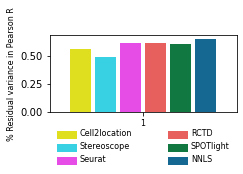

In [41]:
def variance_explained(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    anova_res['perc_sq'] = anova_res['sum_sq'] / anova_res['sum_sq'].sum()
    return anova_res


var_expl_df = pd.DataFrame([variance_explained(pr_data_values.loc[pr_data_values['method'] == method,:])['perc_sq']
              for method in method_names], index=method_names)
var_expl_df['method'] = method_names
var_expl_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Variance in Pearson R explained by txn fine', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Variance in Pearson R explained by cell type abundance', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Residual",
                hue="method",
                data=var_expl_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('% Residual variance in Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

#plt.savefig('suffer' + '/barplot_PR_big.pdf', bbox_inches='tight')

#plt.savefig(fig_path + '/barplot_PR_by_category_txn_distinct_with_label.pdf', bbox_inches='tight')

### Look at effects on Pearson R

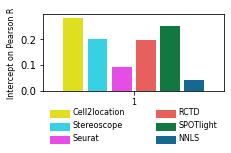

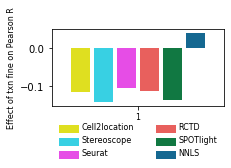

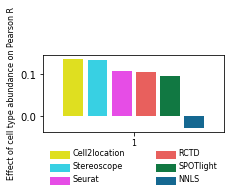

In [42]:
def lm(df):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from re import sub

    lm_model = ols(f'value ~ C(is_txn_fine) + max_density', data=df).fit()
    #anova_res = sm.stats.anova_lm(lm_model, typ=2)
    # Sum of squares for model terms.
    #anova_res['perc_sq'] = anova_res['sum_sq'] / anova_res['sum_sq']['Residual']
    return lm_model

effect_df = pd.DataFrame([lm(pr_data_values.loc[pr_data_values['method'] == method,:]).params 
 for method in method_names], index=method_names)

effect_df['method'] = method_names
effect_df['1'] = 1

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="Intercept",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Intercept on Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="C(is_txn_fine)[T.1]",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Effect of txn fine on Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();

plt.figure(figsize=(3.4, 2.5))
g = sns.barplot(x="1", 
                y="max_density",
                hue="method",
                data=effect_df, palette=sc.pl.palettes.default_102);
change_width(g, .11)
plt.xlabel('');
plt.ylabel('Effect of cell type abundance on Pearson R', size=8);
plt.xticks(size=8, ha='center');
lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.5,  1, 0.1), mode='expand', ncol=2, 
           fontsize=8, frameon=False);
for handle in lgnd.legendHandles:
    handle.set_height(8)
    handle.set_width(20)
    handle.set_y(-3)
plt.tight_layout();
plt.show();